# Demo Run

In [1]:
# %load_ext autoreload
# %autoreload 2
# # # this may cause DisentenglementTargetManager to reimported, losing all the data e.g. configurations.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DeJavu Serif"
plt.rcParams["font.serif"] = ["Times New Roman"]

In [3]:
import os
import sys
import gc
import warnings
import anndata as ad
import scanpy as sc
import numpy as np
import scanpy as sc
import numpy as np

sys.path.append("/Users/kemalinecik/git_nosync/tardis")
import tardis
tardis.config = tardis.config_local

sc.settings.verbosity = 3

In [4]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    adata_file_path = os.path.join(tardis.config.io_directories["processed"], "cpa_Norman2019_prep_new.h5ad")
    assert os.path.isfile(adata_file_path), f"File not already exist: `{adata_file_path}`"
    adata = ad.read_h5ad(adata_file_path)
adata

AnnData object with n_obs × n_vars = 108497 × 5000
    obs: 'cov_drug_dose_name', 'dose_val', 'control', 'condition', 'guide_identity', 'drug_dose_name', 'cell_type', 'split', 'split1', 'split2', 'split3', 'split4', 'split5', 'split6', 'split7', 'split8', 'split9', 'split10', 'split11', 'split12', 'split13', 'split14', 'split15', 'split16', 'split17', 'split18', 'split19', 'split20', 'split21', 'split22', 'split23', 'split24', 'split25'
    var: 'gene_symbols', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'rank_genes_groups_cov'
    layers: 'counts'

In [5]:
adata.X = adata.layers["counts"].copy()
del adata.layers
gc.collect()

32

## Load Model

In [6]:
dir_path = os.path.join(
    tardis.config.io_directories["models"],
    "run12"
)
vae = tardis.MyModel.load(dir_path, adata=adata)

INFO     File /Users/kemalinecik/git_nosync/tardis/data/models/run12/model.pt already downloaded                   


## Check training

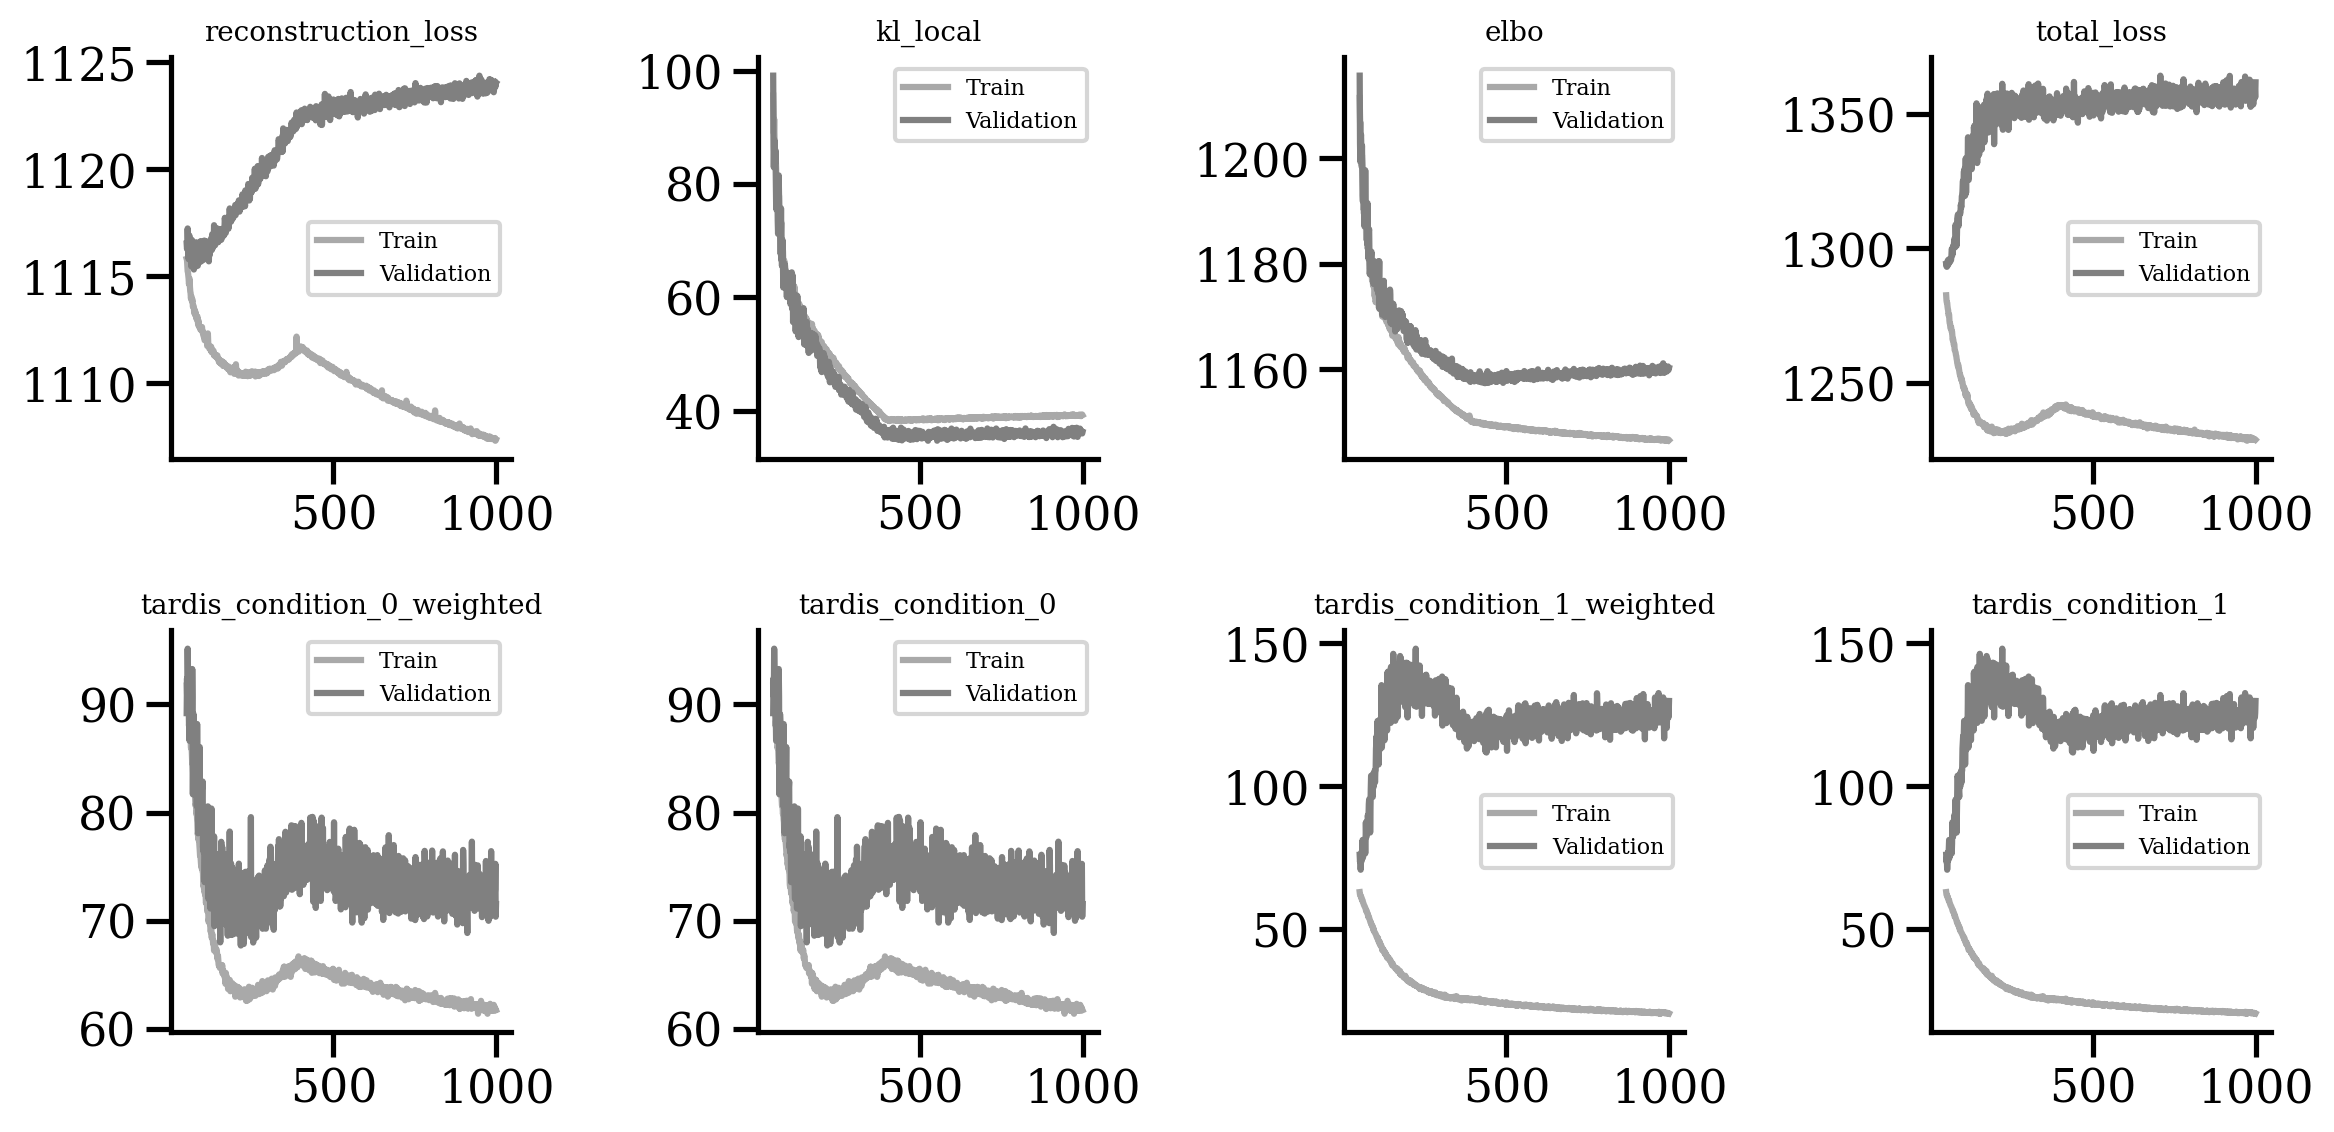

In [10]:
vae.plot_training_history(
    ignore_first=50, 
    n_col=4,
    metrics_name=[
        "reconstruction_loss", "kl_local", "elbo", "total_loss",
        #
        "tardis_condition_0_weighted", 
        "tardis_condition_0",
        "tardis_condition_1_weighted", 
        "tardis_condition_1",
    ]
)

In [11]:
# from tardis._disentenglementtargetmanager import DisentenglementTargetManager
# display(np.array(DisentenglementTargetManager.configurations.get_by_obs_key("age").reserved_latent_indices))
# display(np.array(DisentenglementTargetManager.configurations.get_by_obs_key("sex").reserved_latent_indices))

In [12]:
# vae.plot_latent_kde(
#     adata_obs=adata.obs,
#     target_obs_key="sex",
#     latent_representation=vae.get_latent_representation(),
#     latent_dim_of_interest=None
# )

# Metrics

In [7]:
batch_size_vae_metrics = 512
vae_metrics = {
    "reconstruction_error": vae.get_reconstruction_error(batch_size=batch_size_vae_metrics)['reconstruction_loss'],
    "elbo": vae.get_elbo(batch_size=batch_size_vae_metrics).item(),
    "r2_train": vae.get_reconstruction_r2(batch_size=batch_size_vae_metrics, indices=vae.train_indices),
    # "r2_train_deg_20": vae.get_reconstruction_r2(top_n_differentially_expressed_genes=20, batch_size=batch_size_vae_metrics, indices=vae.train_indices),
    # "r2_train_deg_50": vae.get_reconstruction_r2(top_n_differentially_expressed_genes=50, batch_size=batch_size_vae_metrics, indices=vae.train_indices),
    "r2_validation": vae.get_reconstruction_r2(batch_size=batch_size_vae_metrics, indices=vae.validation_indices),
    # "r2_validation_deg_20": vae.get_reconstruction_r2(top_n_differentially_expressed_genes=20, batch_size=batch_size_vae_metrics, indices=vae.validation_indices),
    # "r2_validation_deg_50": vae.get_reconstruction_r2(top_n_differentially_expressed_genes=50, batch_size=batch_size_vae_metrics, indices=vae.validation_indices),
}
for k, v in vae_metrics.items():
    print(k, v)

reconstruction_error -1107.1203063218338
elbo -1145.841064453125
r2_train 0.9991651971381814
r2_validation 0.9990230634095363


# Visualization

In [14]:
def prepare(ad_latent):
    sc.pp.neighbors(ad_latent, n_neighbors = 30)
    sc.tl.umap(ad_latent)

In [15]:
latent = ad.AnnData(X=vae.get_latent_representation(), obs=adata.obs.copy())
prepare(latent)
latent

computing neighbors
    using data matrix X directly
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:51)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:01:38)


AnnData object with n_obs × n_vars = 108497 × 32
    obs: 'cov_drug_dose_name', 'dose_val', 'control', 'condition', 'guide_identity', 'drug_dose_name', 'cell_type', 'split', 'split1', 'split2', 'split3', 'split4', 'split5', 'split6', 'split7', 'split8', 'split9', 'split10', 'split11', 'split12', 'split13', 'split14', 'split15', 'split16', 'split17', 'split18', 'split19', 'split20', 'split21', 'split22', 'split23', 'split24', 'split25', '_scvi_batch', '_scvi_labels'
    uns: 'neighbors', 'umap'
    obsm: 'X_umap'
    obsp: 'distances', 'connectivities'

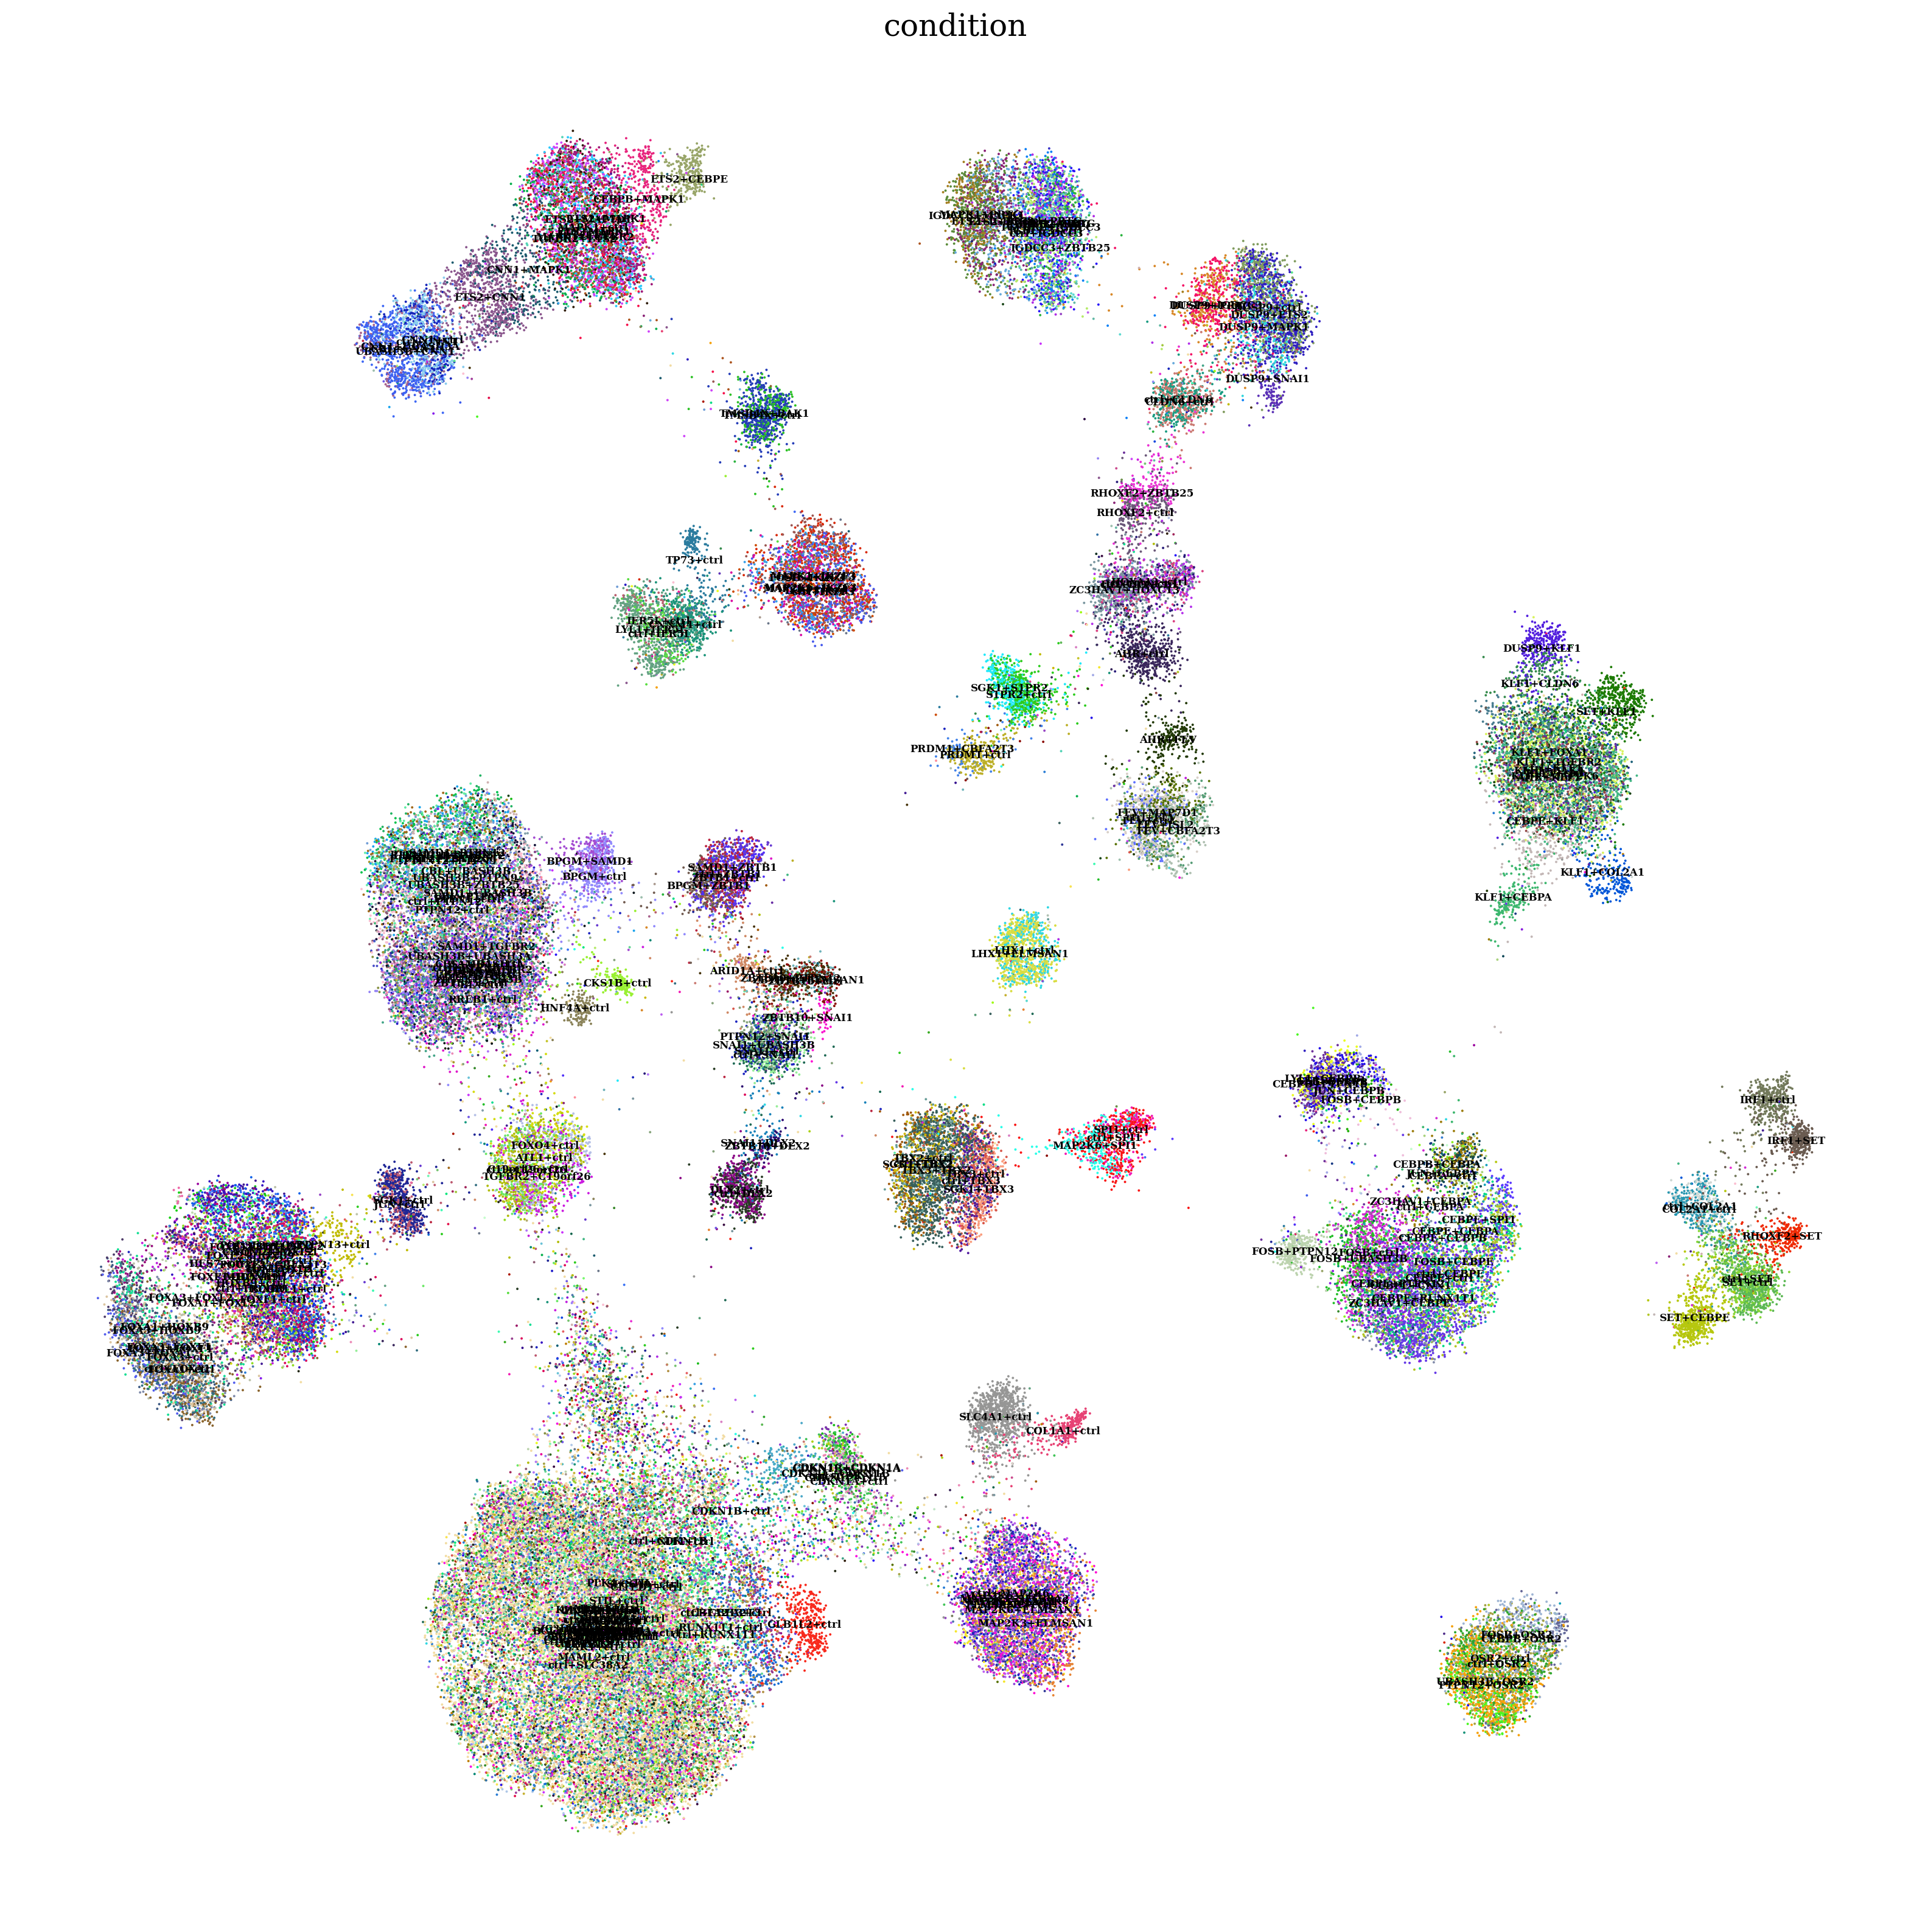

In [16]:
def generate_random_colors(num_colors):
    return ["#"+''.join([np.random.choice(list('0123456789ABCDEF')) for j in range(6)]) for i in range(num_colors)]
unique_cell_types = latent.obs["condition"].unique()
# Generate random colors for each unique cell type
random_colors = generate_random_colors(len(unique_cell_types))
# Create a dictionary to map cell types to colors
color_map = dict(zip(unique_cell_types, random_colors))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    plt.figure(figsize=(20, 20))
    sc.pl.umap(
        latent, 
        color=["condition"], 
        ncols=1,
        size=8,
        frameon=False,
        palette=color_map,
        legend_loc="on data",
        legend_fontsize=6,
        legend_fontweight='bold',
        ax=plt.gca(),
    show=False
    )
plt.show()

In [17]:
del latent
gc.collect();